# Finding Donors for CharityML

<font color='blue'>TASK: to accurately model individuals' income using data collected from the 1994 U.S. Census.</font>

We'd like to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income (or which income category they belong to) can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.

## <font color='blue'>Import libraries & read data</font>

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
from sklearn.model_selection import train_test_split

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
from sklearn.metrics import confusion_matrix

In [36]:
# Read the data
df = pd.read_csv('./census_data.csv')
df.shape

(45222, 15)

In [93]:
# Seperate features & the target variable
y = df['income'] # target
X = df.drop('income', axis= 1) # features

In [94]:
# Convert `y` - the target variable - to binary values.
y = np.array([0 if elm == '<=50K' else 1 for elm in y])

## <font color='blue'>Split data into train & test sets</font>

In [98]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_test.shape[0]} samples.')

Training set has 36177 samples.
Testing set has 9045 samples.


In [99]:
X_train.head(3)

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
7963,7963,32,Private,Bachelors,13.0,Never-married,Exec-managerial,Not-in-family,White,Female,0.0,0.0,40.0,United-States
26402,26402,-1,Private,Assoc-acdm,12.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,66.0,Yugoslavia
31411,31411,45,Self-emp-not-inc,11th,7.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,50.0,United-States


In [100]:
# Drop the clumn 'Unnamed 0'
X_train = X_train.drop('Unnamed: 0', axis= 1)
X_test = X_test.drop('Unnamed: 0', axis= 1)

In [101]:
# Check the percentage of various income categories in training set.
y_train.mean()

0.24623379495259418

''

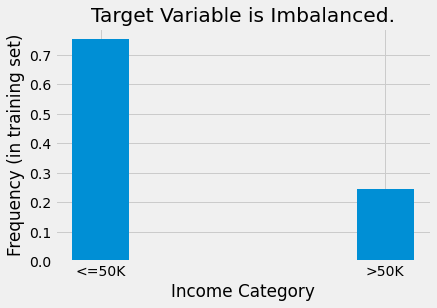

In [103]:
# Show the frequency of people with different income category.
y_counts = pd.Series(y_train).value_counts(normalize= True)
plt.bar(['<=50K', '>50K'], y_counts.values, width= .2)
plt.xlabel('Income Category')
plt.ylabel('Frequency (in training set)')
plt.title('Target Variable is Imbalanced.')
;

From the plot, we can see that the datast is an __inbalanced dataset__, where 25% are in the category of higher income - more than 50K per year. And the reset earn <=50K per annum.

In [106]:
feats_num = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

feats_cat = ['education_level', 'marital-status', 'native-country',
             'occupation', 'race', 'relationship', 'sex', 'workclass']

## <font color='blue'>Preprocessing</font>

### Missing Values

In [105]:
X_train.isna().sum(axis= 0)

age                   0
workclass             0
education_level    3994
education-num         0
marital-status        0
occupation            0
relationship          0
race                  0
sex                   0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country        0
dtype: int64

There are missing values in the __education_level__ column; looking more closely, we see that the column __age__ contains missing data as well.

<AxesSubplot:>

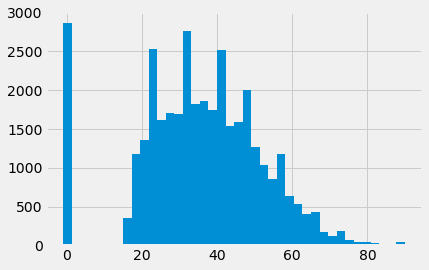

In [23]:
X_train['age'].hist(bins= 40)

In [24]:
# Investigate individuals younger than 20.
X_train.loc[X_train['age'] < 20].head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
43867,-1,Private,Some-college,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
28449,-1,Private,Bachelors,13.0,Divorced,Other-service,Not-in-family,White,Female,0.0,0.0,35.0,United-States
43769,-1,Self-emp-not-inc,Some-college,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,55.0,United-States
22296,19,Private,Some-college,10.0,Never-married,Other-service,Own-child,White,Female,0.0,0.0,30.0,United-States
35148,-1,Self-emp-not-inc,Some-college,10.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States


In [16]:
# It seems that there are some people that their age is missing.
# These values are encoded as `-1`.
# We have to attend to that.
X_train.loc[X_train['age'] < 20, 'age'].value_counts()

-1     2864
 19     638
 18     536
 17     349
Name: age, dtype: int64

In [46]:
X_train['education_level'].value_counts(dropna= False)

 HS-grad         10489
 Some-college     7053
 Bachelors        5418
NaN               3994
 Masters          1763
 Assoc-voc        1391
 11th             1160
 Assoc-acdm       1077
 10th              888
 7th-8th           580
 Prof-school       552
 9th               486
 12th              405
 Doctorate         388
 5th-6th           323
 1st-4th           154
 Preschool          56
Name: education_level, dtype: int64

### Skewed Data

In [103]:
def hist_plots(df, col, transformed = False):
    # Create figure
    fig = plt.figure(figsize = (12, 5));

    # Skewed feature plotting
    for i, kind in enumerate(['orig', 'limit'], start= 1):
        ax = fig.add_subplot(1, 2, i)
        ax.hist(df[col], bins = 25, color = '#00A0A0')
        plot_title = 'original count'
        if kind == 'limit':
            plot_title = 'count limited to 2K for more visibility'

        ax.set_title(plot_title, fontsize = 14)
        ax.set_xlabel('')
        ax.set_ylabel('Counts')
        if kind == 'limit':
            ax.set_ylim((0, 2000))
            ax.set_yticks([0, 500, 1000, 1500, 2000])
            ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

        sup_title = f'{col!r} Feature Distribution'
        if transformed:
            sup_title += ' (Log-transformed)'
            fig.suptitle(sup_title, fontsize= 16, y= 1.03)
        else:
            sup_title += ' (Skewed Distributions)'
            fig.suptitle(sup_title, fontsize= 16, y= 1.03)

    fig.tight_layout()

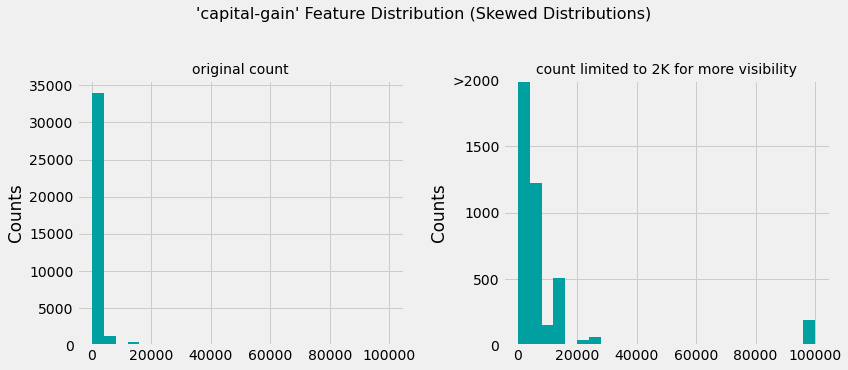

In [104]:
hist_plots(X_train, 'capital-gain')

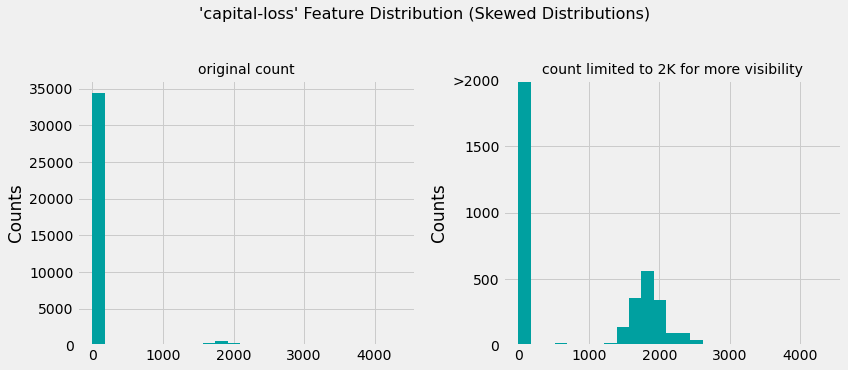

In [105]:
hist_plots(X_train, 'capital-loss')

In [33]:
np.quantile(df['capital-gain'], q= .9), np.quantile(df['capital-gain'], q= .95)

(0.0, 5013.0)

In [37]:
np.quantile(df['capital-loss'], q= .95), np.quantile(df['capital-loss'], q= .99)

(0.0, 1980.0)

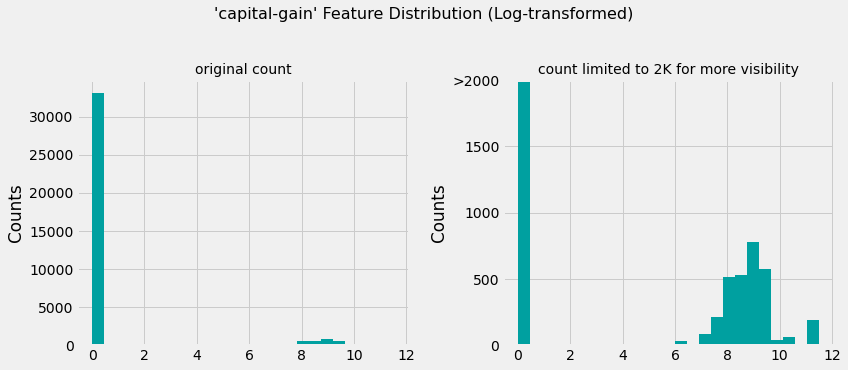

In [107]:
# Transform the features to make them as normally distributed as possible.
X_capital = X_train[['capital-gain', 'capital-loss']].copy()
X_capital['capital-gain'] = np.log(X_capital['capital-gain'] + 1)
X_capital['capital-loss'] = np.log(X_capital['capital-loss'] + 1)

hist_plots(X_capital, 'capital-gain', transformed= True)

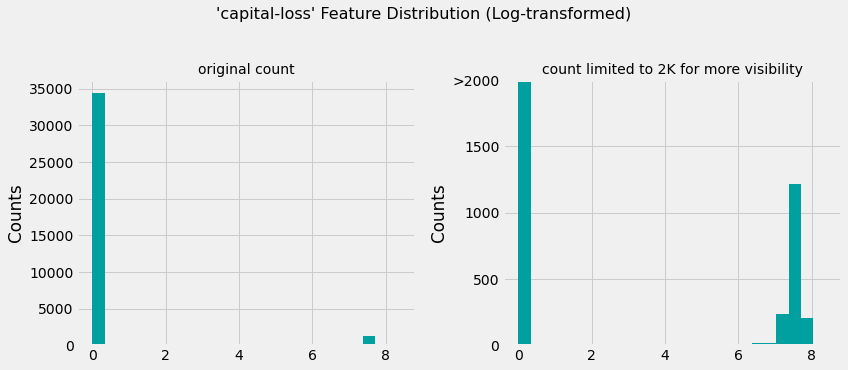

In [108]:
hist_plots(X_capital, 'capital-loss', transformed= True)

## Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [114]:
# Initialize MinMaxScaler.
scaler_max_min = MinMaxScaler() # default=(0, 1)
feats_num = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

X_train_num = X_train[feats_num]
# Apply it to the features.
X_train_num = scaler_max_min.fit_transform(X_train_num)

# Show an example of a record with scaling applied
X_train_num[:10]

array([[0.4109589 , 0.6       , 0.        , 0.        , 0.5       ],
       [0.43835616, 0.53333333, 0.        , 0.        , 0.39795918],
       [0.05479452, 0.66666667, 0.        , 0.        , 0.35714286],
       [0.30136986, 0.86666667, 0.        , 0.45385675, 0.44897959],
       [0.24657534, 0.6       , 0.        , 0.        , 0.5       ],
       [0.31506849, 0.53333333, 0.        , 0.        , 0.39795918],
       [0.05479452, 0.6       , 0.        , 0.        , 0.39795918],
       [0.56164384, 0.4       , 0.        , 0.        , 0.39795918],
       [0.10958904, 0.8       , 0.        , 0.        , 0.39795918],
       [0.23287671, 0.8       , 0.        , 0.        , 0.37755102]])

In [117]:
X_train_num = pd.DataFrame(X_train_num, columns= feats_num)
X_train_num.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week
0,0.410959,0.600000,0.0,0.0,0.500000
1,0.438356,0.533333,0.0,0.0,0.397959
2,0.054795,0.666667,0.0,0.0,0.357143


## Categorical Features: one-hot encoding

In [107]:
# X_train_cat = pd.get_dummies(X_train[feats_cat])
# X_train_clean = pd.concat([X_train_num, X_train_cat], axis= 1)

In [108]:
# Preprocessing for numerical data.
transformer_num = SimpleImputer(strategy= 'constant')

# Preprocessing for categorical data.
# First impute, then do one-hot-encoding.
transformer_cat = Pipeline(steps= [
    ('imputer_cat', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown= 'ignore'))
])

# Bundle preprocessing for numerical and categorical data.
transformer = ColumnTransformer(transformers= [
    ('num', transformer_num, feats_num),
    ('cat', transformer_cat, feats_cat)
])

In [119]:
# Instantiate the classifier.
cls_rf = RandomForestClassifier(n_estimators= 500,
                                max_features= .5,
                                random_state= 0)

In [120]:
# Bundle preprocessing and modeling code in a pipeline
pipe = Pipeline(steps= [
    ('transformer', transformer),
    ('cls', cls_rf)
])

In [121]:
# Preprocessing of training data, fit model 
pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = pipe.predict(X_test)

In [122]:
preds

array([1, 0, 0, ..., 0, 0, 0])

In [123]:
confusion_matrix(y_test, preds)

array([[6200,  545],
       [ 797, 1503]], dtype=int64)

In [124]:
# Accuracy
(preds == y_test).mean()

0.8516307352128247

At least, we beat the baseline/naive model.